In [1]:
from astropy.io import fits
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from csaps import csaps
from scipy.ndimage import median_filter
from astropy.stats import sigma_clip

In [2]:
import veloce_reduction_tools

In [3]:
ORDER, COEFFS, MATCH_LAM, MATCH_PIX, MATCH_LRES, GUESS_LAM, Y0 = veloce_reduction_tools.load_prefitted_ThAr(arm='red')

In [4]:
trace_data = np.load('veloce_trace_green.npz')
traces, summing_ranges = trace_data['traces'], trace_data['summing_ranges']

In [301]:
def normalize_order(flux, order=4):
    
#     plt.plot(flux)

    smoothed_flux = median_filter(flux, 50)
#     plt.plot(smoothed_flux)
    
    f = np.polyfit(np.arange(len(flux)),smoothed_flux,order)
    f = np.polyval(f,np.arange(len(flux)))
#     plt.plot(f)

    flux /= f
    
    return flux

In [7]:
# filename = '24aug30184.fits' # use the flat because of visibility
# spectrum_filename =  os.path.join(os.getcwd(), filename)
# image_data = fits.getdata(spectrum_filename)
# image_data = remove_gaps_and_overscan_bias(image_data, overscan_range=32)
# plt.imshow(image_data, cmap='gray', norm="log")
# offset = X[0][-1]
# for x, y in zip(X, Y):
#     plt.plot(x-offset, y, c='r')
# #     print(len(x), len(y))
# plt.xlim(0,)

In [9]:
### apply this pre-made wavelength solution to ThAr calibrations and check quality

need to combine different exposures to remove oversaturated frames

In [309]:
filename = '24aug30310.fits' # ThAr lamp
spectrum_filename =  os.path.join(os.getcwd(), 'Data', filename)

image_data = fits.getdata(spectrum_filename)

# plt.imshow(image_data, cmap='gray', norm="log")
image_substracted_bias = veloce_reduction_tools.remove_overscan_bias(image_data, overscan_range=32)

# plt.imshow(image_substracted_bias, cmap='gray', norm="log")
extracted_ThAr_orders = veloce_reduction_tools.extract_orders_with_trace(image_substracted_bias, traces, summing_ranges)

(0.0, 4096.0)

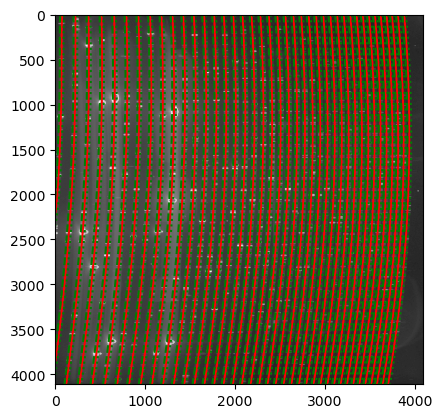

In [310]:
frame = image_substracted_bias.copy()
ylen, xlen = frame.shape
plt.imshow(frame, cmap='gray', norm='log', aspect='equal')
y = np.arange(ylen)

for trace, summing_range in zip(traces, summing_ranges):
    plt.plot(trace,y, c='r')
    plt.plot(trace+summing_range,y, ls=':', c='g')
    plt.plot(trace-summing_range,y, ls='--', c='g')
plt.xlim(0,xlen)

In [5]:
blazes = np.load('veloce_blaze_green_pix.npz')
blazes = blazes['blazes']

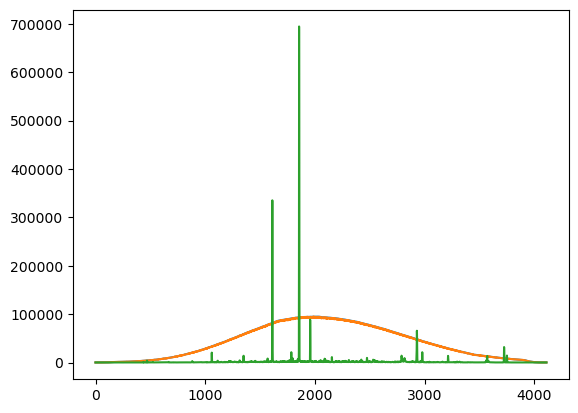

In [11]:
# # for blaze in blazes:
blaze = blazes[6]
x = np.arange(len(blaze))
y = np.array(blaze, dtype=np.float64)

ysm = median_filter(y,50)
ysm /= max(ysm)

plt.plot(ysm*max(blaze))
plt.plot(blaze)
plt.plot(extracted_ThAr_orders[6])
plt.show()

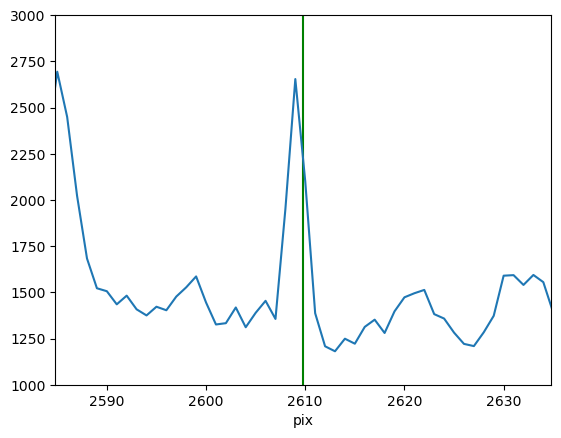

In [318]:
n = 1

# for match_pix in MATCH_PIX[n-1]: ### green part needs shift by one order issue with labeling? 
for match_pix in MATCH_PIX[n]:
    plt.axline([match_pix+Y0[n], 0], [match_pix+Y0[n], 1], c='g')

plt.plot(extracted_ThAr_orders[n])
# plt.xlim(MATCH_PIX[n-1][0]-25+Y0[n],MATCH_PIX[n-1][0]+25+Y0[n])
plt.xlim(MATCH_PIX[n][2]-25+Y0[n],MATCH_PIX[n][2]+25+Y0[n])
# plt.xlim(2350,2400)
plt.ylim(1000,3000)
plt.xlabel('pix')
plt.show()

In [223]:
plt.close('all')

In [18]:
### try to apply it to sience data

In [6]:
filename = '24aug20184.fits' # science frame
spectrum_filename =  os.path.join(os.getcwd(), 'Data', filename)

image_data = fits.getdata(spectrum_filename)

image_substracted_bias = veloce_reduction_tools.remove_overscan_bias(image_data, overscan_range=32)
extracted_science_orders = veloce_reduction_tools.extract_orders_with_trace(image_substracted_bias, traces, summing_ranges)

In [7]:
### green part needs shift by one order issue with labeling? 
corrected_science_orders = extracted_science_orders[1:]
corrected_blazes = blazes[1:]
### red is fine:
# corrected_science_orders = extracted_science_orders.copy()
# corrected_blazes = blazes.copy()

In [8]:
WAVE = veloce_reduction_tools.calibrate_orders_to_wave(corrected_science_orders, Y0[0], COEFFS)

array([[27., 13., 21., ...,  1.,  1.,  5.],
       [13.,  6., 15., ...,  1.,  6.,  5.],
       [ 1.,  7.,  2., ...,  3.,  6.,  2.],
       ...,
       [ 7.,  3.,  1., ...,  1.,  5.,  4.],
       [ 1.,  1.,  2., ...,  3.,  1.,  3.],
       [ 1.,  1.,  1., ...,  1.,  4.,  1.]])

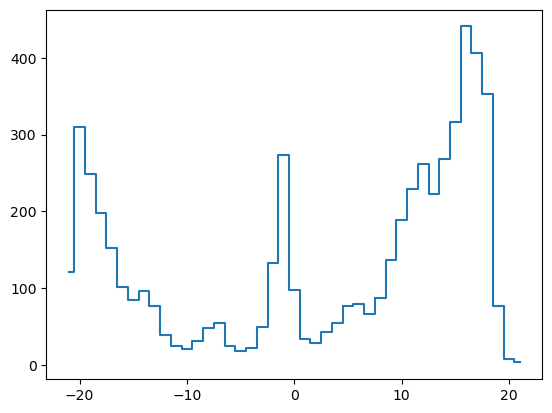

In [326]:
veloce_reduction_tools.plot_order_cross_section(image_substracted_bias, traces, 21, 16)

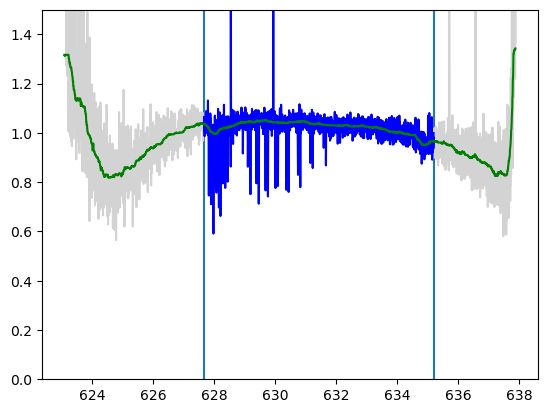

In [327]:
n = 32 # 36 - strong line near top of the order # 2 - Na lines
wave, extracted_science_order, blaze = WAVE[n], corrected_science_orders[n], corrected_blazes[n]
y = np.array(blaze, dtype=np.float64)

#     ysm = csaps(x,blaze,x,smooth=1e-4)
#     ysm /= np.max(ysm)

ysm = median_filter(y,50)
ysm /= max(ysm)

flux = extracted_science_order.copy()
flux /= ysm
flux /= np.median(flux)

# plt.plot(wave, flux)
# flux = normalize_order(np.array(extracted_science_order, dtype=np.float64)/ysm, order=5)
# plt.xlim(wave[0],wave[-1])
# plt.xlim(514,516)
plt.ylim(0,1.5)
pix_max = len(wave)
cutoff = 1000
plt.axline([wave[cutoff],0], [wave[cutoff],1])
plt.axline([wave[pix_max-cutoff],0], [wave[pix_max-cutoff],1])
plt.plot(wave, flux, c='lightgrey')
plt.plot(wave[cutoff:pix_max-cutoff], flux[cutoff:pix_max-cutoff], c='blue')
plt.plot(wave, median_filter(flux,100), c='green')

plt.show()

In [328]:
final_wave = []
final_flux = []
for wave, extracted_science_order, blaze in zip(WAVE, corrected_science_orders, corrected_blazes):
    y = np.array(blaze, dtype=np.float64)

    ysm = median_filter(y,50)
    ysm /= max(ysm)

    flux = extracted_science_order.copy()
    flux /= ysm
    flux /= np.median(flux)
    # flux = normalize_order(flux, order=1)

    # plt.ylim(0,1.5)
    pix_max = len(wave)
    cutoff = 1000
    # plt.plot(wave, flux, c='lightgrey')
    # plt.plot(wave[cutoff:pix_max-cutoff], flux[cutoff:pix_max-cutoff], c='blue')
    # plt.plot(wave, median_filter(flux,100), c='green')
    final_wave.append(wave[cutoff:pix_max-cutoff])
    final_flux.append(flux[cutoff:pix_max-cutoff])

final_wave = np.array(final_wave)
final_flux = np.array(final_flux)

# plt.show()

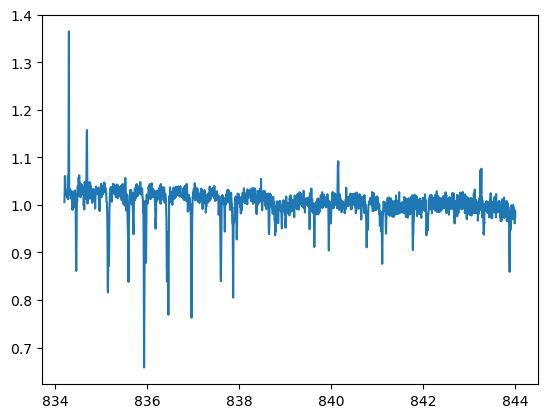

In [329]:
n=8
plt.plot(final_wave[n],final_flux[n])

In [330]:
np.savez('veloce_test_red', wave=final_wave, flux=final_flux)

In [10]:
np.savez('veloce_blaze_green_wave', wave=WAVE, blaze=corrected_blazes)